In [195]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
import jax.random as jr
import optax
from diffrax import diffeqsolve,Tsit5, ODETerm, SaveAt
import pandas as pd

jax.config.update("jax_enable_x64", True)
colors = sns.color_palette()


# Example – The catalysis Problem using a Classical Approach

This is Example 3.1 of [Tsilifis (2014)](http://arxiv.org/abs/1410.5522).

Consider the catalytic conversion of nitrate ($\text{NO}_3^-$) to nitrogen ($\text{N}_2$) and other by-products by electrochemical means. The mechanism that is followed is complex and not well understood. The experiment of [Katsounaros (2012)](http://www.sciencedirect.com/science/article/pii/S0013468612005208) confirmed the production of nitrogen ($\text{N}_2$), ammonia ($\text{NH}_3$), and nitrous oxide ($\text{N}_2\text{O}$) as final products of the reaction, as well as the intermediate production of nitrite ($\text{NO}_2^-$).

The time is measured in minutes and the concentrations are measured in $\text{mmol} \cdot \text{L}^{-1}$.

In [196]:
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)
catalysis_data

,NO3,NO2,N2,NH3,N2O
Time,,,,,
0,500.00,0.00,0.00,0.00,0.00
30,250.95,107.32,18.51,3.33,4.98
60,123.66,132.33,74.85,7.34,20.14
90,84.47,98.81,166.19,13.14,42.10
120,30.24,38.74,249.78,19.54,55.98
150,27.94,10.42,292.32,24.07,60.65
180,13.54,6.11,309.50,27.26,62.54


Let's plot the data.

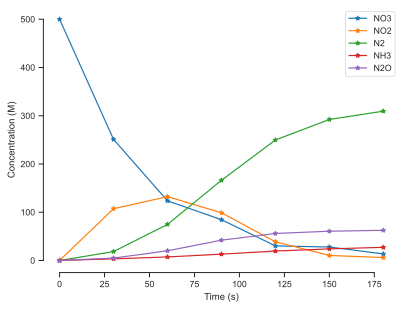

In [197]:
fig, ax = plt.subplots()
time = catalysis_data.index
for col in catalysis_data.columns:
    ax.plot(time, catalysis_data[col], '-*', label=col)
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration (M)')
sns.despine(trim=True)
plt.show()

The theory of catalytic reactions guarantees that the total mass must be conserved.
However, this is not the case in our dataset:

In [198]:
catalysis_data.sum(axis=1)

Time
0      500.00
30     385.09
60     358.32
90     404.71
120    394.28
150    415.40
180    418.95
dtype: float64

This inconsistency suggests the existence of an intermediate unobserved reaction product X. [(Katsounaros, 2012)](http://www.sciencedirect.com/science/article/pii/S0013468612005208) suggested the following reaction path shown in the figure below.

![](scheme.png "Reaction Scheme")

The dynamical system associated with the reaction is:

$$
\begin{array}{cc}
\frac{d \left[\text{NO}_3^-\right]}{dt} &= -k_1\left[\text{NO}_3^-\right], \\\\
\frac{d\left[\text{NO}_2^-\right]}{dt} &= k_1\left[\text{NO}_3^-\right] - (k_2 + k_4 + k_5)[\text{NO}_2^-], \\\\
\frac{d \left[\text{X}\right]}{dt} &= k_2 \left[\text{NO}_2^-\right] - k_3 [\text{X}],\\\\
\frac{d \left[\text{N}_2\right]}{dt} &= k_3 \left[\text{X}\right], \\\\
\frac{d \left[\text{NH}_3\right]}{dt} &= k_4 \left[\text{NO}_2^-\right],\\\\
\frac{d \left[\text{N}_2\text{O}\right]}{dt} &= k_5 \left[\text{NO}_2^-\right],
\end{array}
$$

where $[\cdot]$ denotes the concentration of a quantity, and $k_i > 0$, $i=1,...5$ are the *kinetic rate constants*.

### Formulation of the Inverse Problem

#### Step 1: Making our life easier by simplifying the notation
Note that this is actually a linear system.
To simplify our notation, let's define:

$$
\begin{array}{ccc}
z_1 &:=& \left[\text{NO}_3^-\right],\\
z_2 &:=& \left[\text{NO}_2^-\right],\\
z_3 &:=& \left[\text{X}\right],\\
z_4 &:=& \left[\text{N}_2\right],\\
z_5 &:=& \left[\text{NH}_3\right],\\
z_6 &:=& \left[\text{N}_2\text{O}\right],
\end{array}
$$

the vector:

$$
z = (z_1,z_2,z_3,z_4,z_5,z_6),
$$

and the matrix:

$$
A(k_1,\dots,k_5) = \left(\begin{array}{cccccc}
-k_1 & 0 & 0 & 0 & 0 & 0\\
k_1 & -(k_2+k_4+k_5) & 0 & 0 & 0 & 0\\
0 & k_2 & -k_3 & 0 & 0 & 0\\
0 & 0 & k_3 & 0 & 0 & 0\\
0 & k_4 & 0 & 0 & 0 & 0\\
0 & k_5 & 0 & 0 & 0 & 0
\end{array}\right)\in\mathbb{R}^{6\times 6}.
$$

With these definitions, the dynamical system becomes:

$$
\dot{z} = A(k_1,\dots,k_5)z,
$$

with initial conditions:

$$
z(0) = z_0 = (500, 0, 0, 0, 0, 0)\in\mathbb{R}^6,
$$

read directly from the experimental data.
What we are definitely going to need is a solver for this system.
That's easy.
Let's denote the solution of the system at time $t$ by:

$$
z(t;k_1,\dots,k_5).
$$

#### Step 2: Scale the unknown parameters to your best of your abilities
The constraints you have on your parameters, the better.
If you do have constraints, you would have to use constrained optimization algorithms.
The way you scale things depend on the problem.
Here we would think as follows:

+ $k_i$ has units of inverse time. It is proparly appropriate to scale it with the total time which is 180 minutes.
So, let's just multiply $k_i$ with 180. This makes the resulting variable dimensionless:

$$
\hat{x}_i = 180k_i.
$$

+ $k_i$ is positive, therefore $\hat{x_i}$ must be positive.
So, let's just work with the logarithm of $\hat{x_i}$:

$$
x_i = \log \hat{x_i} = \log 180k_i.
$$

+ define the parameter vector:

$$
x = (x_1,\dots,x_5)\in\mathcal{X} = \mathbb{R}^5.
$$

From now on, we will write:

$$
A = A(x),
$$

for the matrix of the dynamical system, and

$$
z = z(t;x),
$$

for the solution at $t$ given that the parameters are $x$.

#### Step 3: Making the connection between our model and the experimental measurements
Our experimental data include measurements of everything except $z_3$ at times six (6) time instants:

$$
t_j = 30j\;\text{minutes},
$$

$j=1,\dots,6$.

Now, let $Y\in\mathbb{R}^{5\times 6}$ be the experimental measurements:

In [199]:
catalysis_data[1:]

,NO3,NO2,N2,NH3,N2O
Time,,,,,
30,250.95,107.32,18.51,3.33,4.98
60,123.66,132.33,74.85,7.34,20.14
90,84.47,98.81,166.19,13.14,42.10
120,30.24,38.74,249.78,19.54,55.98
150,27.94,10.42,292.32,24.07,60.65
180,13.54,6.11,309.50,27.26,62.54


You can think of the measurements as vector by flattening the matrix:

$$
y = \operatorname{vec}(Y)\in\mathbb{R}^{30}.
$$

Note that ``vec`` is the vectorization operator.

What is the connection between the solution of the dynamical system $z(t,x)$ and the experimental data?
It is as follows:

$$
\begin{array}{ccc}
z_1(30j;x) &\longrightarrow& Y_{j1},\\
z_2(30j;x) &\longrightarrow& Y_{j2},\\
z_4(30j;x) &\longrightarrow& Y_{j3},\\
z_5(30j;x) &\longrightarrow& Y_{j4},\\
z_6(30j;x) &\longrightarrow& Y_{j5},
\end{array}
$$

for $j=1,\dots,6$.

We are now ready to define a function:

$$
f:\mathcal{X} \rightarrow \mathcal{Y}=\mathbb{R}^{30}_+,
$$

as follows:
+ Define the matrix function:

$$
F:\mathcal{X} \rightarrow \mathbb{R}^{5\times 6},
$$

by:

$$
\begin{array}{ccccc}
F_{j1}(x) &=& z_1(30j;x)&\longrightarrow& Y_{j1},\\
F_{j2}(x) &=& z_2(30j;x) &\longrightarrow& Y_{j2},\\
F_{j3}(x) &=& z_4(30j;x) &\longrightarrow& Y_{j3},\\
F_{j4}(x) &=& z_5(30j;x) &\longrightarrow& Y_{j4},\\
F_{j5}(x) &=& z_6(30j;x) &\longrightarrow& Y_{j5},
\end{array}
$$

+ And flatten that function:

$$
f(x) = \operatorname{vec}(F(x))\in\mathbb{R}^{30}.
$$

Now, we have made the connection with our theoretical formulation of inverse problems crystal clear.

#### Step 4: Programming our solver and the loss function

First let's define the system of ODEs.

In [ ]:
# Define the linear system
def A(x):
    """
    Return the matrix of the dynamical system.
    """
    k = jnp.exp(x) / 180.0
    res = jnp.zeros((6, 6))
    res = res.at[0, 0].set(-k[0])
    res = res.at[1, 0].set(k[0])
    res = res.at[1, 1].set(-(k[1] + k[3] + k[4]))
    res = res.at[2, 1].set(k[1])
    res = res.at[2, 2].set(-k[2])
    res = res.at[3, 2].set(k[2])
    res = res.at[4, 1].set(k[4])
    res = res.at[5, 1].set(k[3])
    return res

def dynamic_sys(t, z, x):
    return jnp.dot(A(x), z)

Now, let's use diffrax for our ODE solver. We have to extract the experiment times, even though our ODE does not depend on it, the solver needs to know how long to solve the ODE for and where to save the solution.

In [201]:
# Experimental times
t_exp = jnp.array(catalysis_data.index.values)
t0 = t_exp[0]
t1 = t_exp[-1]

# Solve the ODE using Diffrax
def solve_catalysis(t, x, z0):

    sol = diffeqsolve(
        ODETerm(dynamic_sys),
        Tsit5(),
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=z0,
        args=x,
        saveat=SaveAt(ts=t),
        max_steps=100_000,
    )
    return sol.ys


We can solve this ODE and find the model parameters by minimizing a loss function. Here we extract the result of the solver for the concentrations that we measure and compare it to the experimental data.

In [202]:
# Define the loss function to minimize
def loss(x, z, y, t):

    # Compute the solution
    res = solve_catalysis(t, x, z)

    # Extract the concentration of the species of interest
    flat_res = jnp.hstack([res[:, :2], res[:, 3:]]).flatten()

    # Scaled for numerical stability
    loss_val = 0.5 * jnp.sum((flat_res / 500. - y / 500.) ** 2) 

    return loss_val

Via this loss function, we can use Adam to do gradient descent and find the model parameters that best fit the data.

In [ ]:
# Initial guess for x
key = jr.PRNGKey(0)
x0 = jr.normal(key, shape=(6,))  

# Initial conditions
z0 = jnp.array([500., 0., 0., 0., 0., 0.0])

# Extract the experimental data
Y = catalysis_data.values
y = Y.flatten()

# Set up the optimizer
optimizer = optax.adam(learning_rate=1e-1)
opt_state = optimizer.init(x0)

x = x0  # Initialize x

# Use as many iterations as needed
num_iterations = 100
loss_evol = []

# Optimization loop
for i in range(num_iterations):

    # Compute the gradient of the loss function
    grad_fn = jit(grad(loss))

    grads = grad_fn(x, z0, y, t_exp)

    # Update the optimizer state
    updates, opt_state = optimizer.update(grads, opt_state)

    # Update the parameters
    x = optax.apply_updates(x, updates)

    value = loss(x, z0, y, t_exp)
    loss_evol.append(value)
    
    # Print the loss every 100 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, loss: {value}")

Iteration 0, loss: 0.755381483443839
Iteration 10, loss: 0.3979447060871492
Iteration 20, loss: 0.05037459219852011
Iteration 30, loss: 0.05163229122593369
Iteration 40, loss: 0.027938358442125638
Iteration 50, loss: 0.02010936227847001
Iteration 60, loss: 0.01225592749429492
Iteration 70, loss: 0.009989040813976603
Iteration 80, loss: 0.008045142548508652
Iteration 90, loss: 0.007459423369245389


Let's see how the minimization went.

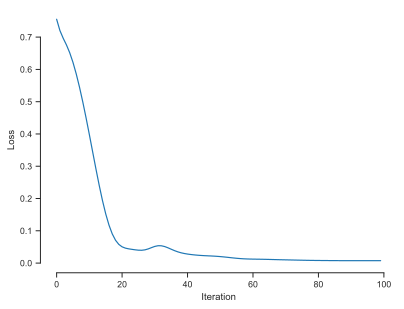

In [204]:
fig, ax = plt.subplots()
ax.plot(loss_evol)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
sns.despine(trim=True)
plt.show()

Great, it looks like it has converged. Let's plot the results of the model against our experimental data to see how well we did.

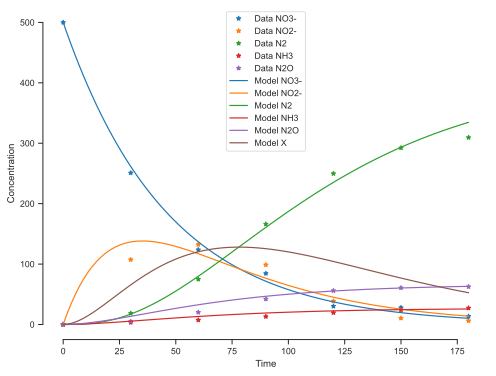

Estimated parameters x: [ 1.35785331  1.67676636  1.34784385 -0.13698413 -1.03691219  0.69261991]


In [205]:
x_est = x
t_exp = jnp.array(catalysis_data.index.values)

# Generate predictions using the estimated parameters
t_plot = jnp.linspace(0.0, 180.0, 100)
Yp = solve_catalysis(t_plot, x_est, z0)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define labels and colors
labels = ['NO3-', 'NO2-', 'N2', 'NH3', 'N2O', 'X']
data_cols = ['NO3', 'NO2', 'N2', 'NH3', 'N2O']
model_cols = [0, 1, 3, 4, 5, 2]

# Plot experimental data
for i, col in enumerate(data_cols):
    ax.plot(t_exp, catalysis_data[col], '*', color=colors[i], label=f'Data {labels[i]}')

# Plot model predictions
for i, col in enumerate(model_cols):
    ax.plot(t_plot, Yp[:, col], color=colors[i], label=f'Model {labels[i]}')

ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
plt.legend()
sns.despine(trim=True)
plt.show()

print("Estimated parameters x:", x_est)

### Questions

+ Are you satisfied with the above model calibration?
+ Rerun the code with a different seed. Does the algorithm always work? Do you find exactly the same $x$?
+ Start from an initial $x$ that is very far away from the zero. Like all 10's. What do you find?
+ What is the average number of function evaluations that you need? Can this method be easily applied to expensive models?

## Shortcomings of the Classic Approach

There are several shorcomings of the classical approach to model calibration which we will remedy in the next lecture.
Here we briefly mention some:

+ The problems are ill-posed. Solutions may not exist. More than one solutions may exist.
+ No apparent way to quantify uncertainties.
+ No systematic way to account for prior knowledge.